In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np

my_data = pd.read_csv('train.csv')

# Тестовое задание - Елькин СВ

### загрузим данные, посмотрим, что там

In [99]:
my_data

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1


### взглянем, что как распределены баги в репозиториях

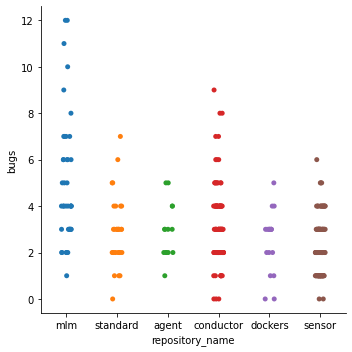

In [100]:
sns.catplot(x='repository_name',
            y='bugs',
            data=my_data);

### как связано количество багов и авторов

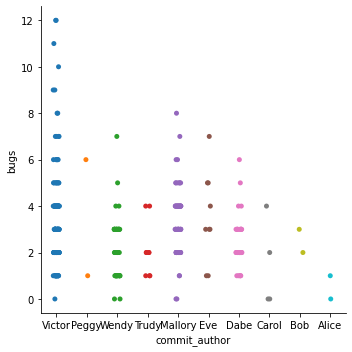

In [101]:
sns.catplot(x='commit_author',
            y='bugs',
            data=my_data);

### глянем, как связаны авторы и баги, подсветив репозитории

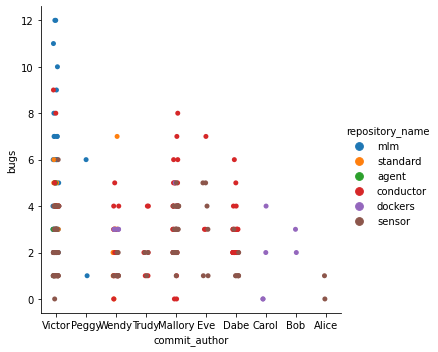

In [102]:
sns.catplot(x='commit_author',
            y='bugs',
            hue='repository_name',
            data=my_data);

## Что мы имеем и что можно предположить
#### Я предположу, что можно построить модель линейной регрессии - предположить значение параметра bugs по введенным параметрам
**Сложности** <br>
1 - почти все параметры - категориальные признаки <br>
2 - признаков несколько - какие выбрать

## Каков план
Я буду тестировать гипотезу, что на количество багов могут влиять такие факторы как "автор" и "репозиторий" <br>
Первым делом применим встроеный метод one-hot encoding.


In [103]:
from sklearn.preprocessing import LabelBinarizer

In [104]:
repository_to_vector = LabelBinarizer()
repository_to_vector.fit(my_data['repository_name'])
transformed = repository_to_vector.transform(my_data['repository_name'])
new_df = pd.DataFrame(transformed)
my_data = pd.concat([my_data, new_df], axis=1).drop(['repository_name'], axis=1)

In [105]:
commit_to_vector = LabelBinarizer()
commit_to_vector.fit(my_data['commit_author'])
transformed = commit_to_vector.transform(my_data['commit_author'])
new_df = pd.DataFrame(transformed)
my_data = pd.concat([my_data, new_df], axis=1).drop(['commit_author'], axis=1)

### перемешаем данные - будет полезно при обучении

In [106]:
my_data = my_data.sample(frac = 1) 
my_data

,commit_hash,commit_date,commit_message,bugs,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
57,183b3517,2020-05-06T16:50:10,Импортировал зависимости для вебхука,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
71,a02a28ef,2020-06-08T07:54:27,Делать бэкап при первом запуске,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
249,9950eb18,2020-04-30T09:32:01,acl права в update.sh,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
150,831a8b6e,2020-04-06T16:36:00,Popen service enabling/disabling; removing ima...,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
87,dea39c26,2020-06-10T16:30:46,fix IMAGES when wrong yaml,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,ebada797,2020-03-28T13:10:53,copy filebeat configs revucrsive,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
70,8a79f45a,2020-06-09T12:07:38,self deploy,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
135,9b0f5187,2020-04-13T12:57:17,compose configs moved to traps/docker,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
220,09a3e460,2020-06-04T18:28:36,add rules folder,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


### Выкинем другие столбцы, кроме "багов"

In [107]:
my_data = my_data.drop(['commit_hash','commit_date','commit_message'], axis=1)

### Посмотрим, что получилось

In [108]:
my_data

,bugs,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
57,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
71,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
249,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
150,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
87,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
70,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
135,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
220,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


###  Начнем строить нашу модель - добавим библиотеку и сделаем тренировочную и тестовую выборку

In [109]:
from sklearn.linear_model import LinearRegression

In [110]:
model = LinearRegression(fit_intercept=True)

In [111]:
checker = my_data['bugs']

In [112]:
my_data.drop(['bugs'], axis=1)

,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
57,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
249,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
150,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
135,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
220,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [113]:
train_data = my_data[:-45]
train_label = checker[:-45]
test_data = my_data[-45:]
test_label = checker[-45:]

### Протренируем нашу модель

In [114]:
model.fit(train_data, train_label)

LinearRegression()

In [115]:
model.intercept_

2.220446049250313e-15

In [116]:
model.coef_

array([ 1.00000000e+00,  8.93624528e-17,  3.22245916e-17, -1.00408872e-17,
        5.16049048e-17,  1.21071836e-16, -3.28514270e-16, -9.01972334e-18,
        1.72939142e-17,  7.60852982e-19, -2.08987545e-17, -1.58334705e-17,
       -2.55747409e-17,  1.92504812e-17, -1.93461008e-17, -9.88991672e-17,
        1.58649912e-16])

### Смещение и веса выстроены. Проверим, насколько хорошо это нам получилось
Для этого будем использовать *коэффициент детерминации* - он же $ R^2 $ - чем ближе к 1, тем точнее

In [117]:
from sklearn.metrics import r2_score

In [118]:
predicted_data = model.predict(test_data)

In [119]:
r2_score(predicted_data, test_label)

1.0

### Данные удалось отлично описать - значит данные жестко детерминированы
#### Давайте посмотрим, что похожи ли последние 5 предсказаных багов и то, как в реальности даны

In [120]:
predicted_data[-5:]

array([3., 1., 4., 1., 2.])

In [121]:
test_label[-5:]

305    3
70     1
135    4
220    1
309    2
Name: bugs, dtype: int64

### На все уточняющие вопросы готов ответить)